In [1]:
from utils import *

VISUALIZE_EMBEDDINGS = False #True

## Prepare Data

In [2]:
all_data = prepare_full_MNIST_databunch()
toytest = ToyAnomalyDetection(all_data, n_anomaly_labels=5, n_cases=10, distance='cosine')

## 1. Conventional softmax model

In [3]:
# Define model learner
def learner_conventional(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(3)
    return learn

def visualize_learner_embeddings(learn, title):
    embs = get_embeddings(body_feature_model(learn.model), all_data.valid_dl)
    show_2D_tSNE(embs, [int(y) for y in all_data.valid_ds.y], title=title)

if VISUALIZE_EMBEDDINGS:
    learn = learner_conventional(all_data)
    visualize_learner_embeddings(learn, 'Simply trained ResNet18 (t-SNE)')    

In [4]:
# Test model
toytest.do_tests('Conventional', learner_conventional)

Testing Conventional for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.516685,0.438560,0.849002,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.088827,0.029178,0.989920,00:08
1,0.048466,0.020292,0.994034,00:08
2,0.019906,0.008339,0.997737,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing Conventional for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.442359,0.371190,0.868054,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.092375,0.014967,0.995353,00:08
1,0.046238,0.016405,0.994544,00:08
2,0.014681,0.006896,0.997777,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing Conventional for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.367553,0.323322,0.888607,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.062741,0.031796,0.988490,00:08
1,0.032587,0.012272,0.996489,00:08
2,0.012904,0.009699,0.997269,00:08


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing Conventional for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.390660,0.330449,0.885965,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.073014,0.025300,0.992203,00:08
1,0.039315,0.017404,0.995517,00:08
2,0.010467,0.005332,0.998441,00:08


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing Conventional for case #4


epoch,train_loss,valid_loss,accuracy,time
0,0.376424,0.279597,0.904956,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.080267,0.034119,0.990515,00:08
1,0.033000,0.007755,0.997677,00:08
2,0.010743,0.005764,0.997871,00:08


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing Conventional for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.296244,0.213175,0.922942,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.061739,0.017322,0.995135,00:08
1,0.023941,0.008456,0.998054,00:08
2,0.006854,0.004691,0.998443,00:08


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing Conventional for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.405161,0.294753,0.899030,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.069463,0.018382,0.994852,00:08
1,0.032428,0.011027,0.996832,00:08
2,0.013197,0.006632,0.998020,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing Conventional for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.500520,0.410929,0.850636,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.088954,0.018332,0.993435,00:08
1,0.032306,0.014442,0.996307,00:08
2,0.008325,0.006292,0.998359,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing Conventional for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.456249,0.341894,0.881930,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.069189,0.068575,0.976591,00:08
1,0.037587,0.013836,0.995893,00:08
2,0.011303,0.007357,0.998152,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing Conventional for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.451822,0.330651,0.890360,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.082368,0.022130,0.992346,00:08
1,0.041169,0.013115,0.995863,00:08
2,0.018366,0.005625,0.998552,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


In [5]:
distance_df, (auc, fpr, tpr), worst_test_info = toytest.results['Conventional'][0]
worst_test_info

,x,y,distance,train_idx,train_x,train_y
1304,0/img0_001621.png,0,0.000588,6047,6/img6_046811.png,6
2049,4/img4_002130.png,4,0.000601,5255,9/img9_047933.png,9
2207,4/img4_000902.png,4,0.000800,4844,9/img9_055102.png,9
2315,4/img4_008406.png,4,0.000867,3863,9/img9_002779.png,9
3716,3/img3_004635.png,3,0.000875,2000,5/img5_029120.png,5


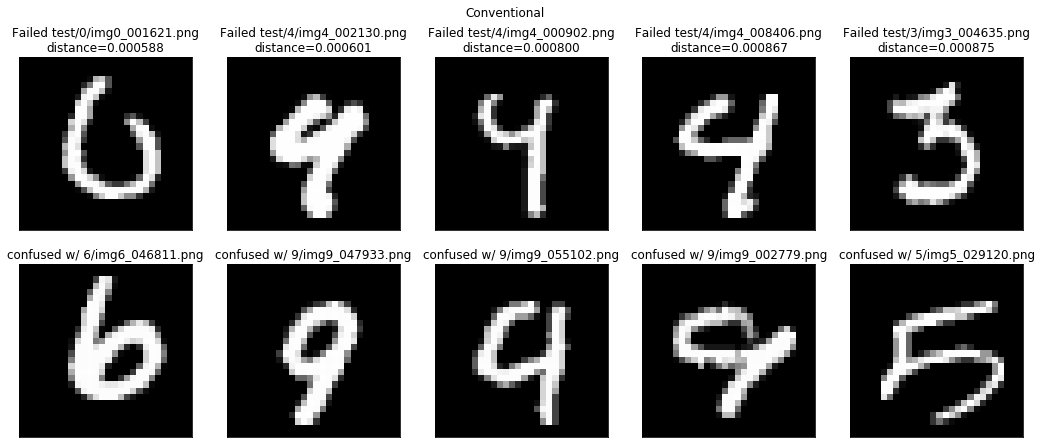

In [6]:
toytest.show_worst_test_images('Conventional', worst_test_info, 0)

## 2. L2-constrained Softmax Loss

- R. Ranjan, C. D. Castillo, and R. Chellappa. L2-constrained softmax loss for discriminative face verification. arXiv preprint arXiv:1703.09507, 2017. https://arxiv.org/pdf/1703.09507.pdf

In [7]:
# Define model learner
class L2ConstrainedNet(nn.Module):
    def __init__(self, org_model, alpha=16, num_classes=1000):
        super().__init__()
        self.org_model = org_model
        self.alpha = alpha

    def forward(self, x):
        x = self.org_model(x)
        
        l2 = torch.sqrt((x**2).sum())
        x = self.alpha * (x / l2)
        return x

def learner_L2ConstrainedNet(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = L2ConstrainedNet(learn.model)
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_L2ConstrainedNet(all_data), 'L2 constrained ResNet18 (t-SNE)')

In [8]:
toytest.do_tests('L2-constrained', learner_L2ConstrainedNet)

Testing L2-constrained for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.702230,0.671808,0.849002,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.416096,0.405844,0.973051,00:08
1,0.402048,0.369153,0.993211,00:08
2,0.391575,0.373673,0.990125,00:08
3,0.378696,0.361723,0.996503,00:08
4,0.375520,0.361427,0.996914,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing L2-constrained for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.675058,0.637932,0.866842,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.412526,0.371034,0.992726,00:08
1,0.403335,0.367298,0.994342,00:08
2,0.385855,0.363551,0.996161,00:08
3,0.380279,0.362200,0.996161,00:08
4,0.375361,0.359325,0.997777,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing L2-constrained for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.628121,0.585709,0.897971,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.410575,0.375365,0.991611,00:08
1,0.402477,0.366037,0.994928,00:08
2,0.387946,0.362942,0.996489,00:08
3,0.377948,0.358841,0.998049,00:08
4,0.375264,0.359524,0.998244,00:08


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing L2-constrained for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.581448,0.533807,0.927029,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.398847,0.364353,0.996692,00:08
1,0.389796,0.362836,0.996303,00:08
2,0.383414,0.358398,0.998638,00:08
3,0.376000,0.357064,0.999222,00:08
4,0.372661,0.355981,0.999222,00:08


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing L2-constrained for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.633049,0.581492,0.902990,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.412408,0.374548,0.991685,00:08
1,0.392866,0.363778,0.996436,00:08
2,0.383319,0.360942,0.997426,00:08
3,0.376259,0.359364,0.998020,00:08
4,0.372436,0.358833,0.998614,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing L2-constrained for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.707984,0.660349,0.855970,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.404000,0.374001,0.990767,00:08
1,0.396674,0.366573,0.994050,00:08
2,0.384756,0.364794,0.995076,00:08
3,0.376313,0.359270,0.997538,00:08
4,0.377793,0.358983,0.997948,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing L2-constrained for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.681668,0.618259,0.884600,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.412138,0.368730,0.993224,00:08
1,0.394523,0.364950,0.994867,00:08
2,0.388517,0.363680,0.995688,00:08
3,0.377096,0.360604,0.997125,00:08
4,0.374949,0.359365,0.997947,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing L2-constrained for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.661163,0.597889,0.892636,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.417834,0.372412,0.993173,00:08
1,0.398111,0.372743,0.991725,00:08
2,0.385876,0.360228,0.996897,00:08
3,0.378926,0.360719,0.997311,00:08
4,0.372954,0.357189,0.998966,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


## 3. ArcFace

- J. Deng, J. Guo, and S. Zafeiriou. Arcface: Additive angular margin loss for deep face recognition. arXiv preprint arXiv:1801.07698, 2018. https://arxiv.org/pdf/1801.07698.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

In [9]:
try:
    from metrics import *
except:
    ! wget https://raw.githubusercontent.com/ronghuaiyang/arcface-pytorch/master/models/metrics.py
    from metrics import *

In [10]:
class LabelCatcher(LearnerCallback):
    last_labels = None

    def __init__(self, learn:Learner):
        super().__init__(learn)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        LabelCatcher.last_labels = last_target
        return {'last_input': last_input, 'last_target': last_target} 


class XFaceNet(nn.Module):
    def __init__(self, org_model, data, xface_product=ArcMarginProduct, m=0.5):
        super().__init__()
        self.org_model = org_model
        self.feature_model = body_feature_model(org_model)
        self.metric_fc = xface_product(512, data.c, m=m).cuda()
    
    def forward(self, x):
        x = self.feature_model(x)
        x = self.metric_fc(x, LabelCatcher.last_labels)
        return x


def learner_ArcFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, ArcMarginProduct, m=0.5)
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_ArcFace(all_data), 'ArcFace (t-SNE)')

In [11]:
toytest.do_tests('ArcFace', learner_ArcFace)

Testing ArcFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,4.600486,4.065303,0.757252,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.045326,0.317951,0.983954,00:08
1,0.819650,0.402779,0.986423,00:08
2,0.463477,0.677761,0.977988,00:08
3,0.274543,0.135187,0.995680,00:08
4,0.155754,0.093972,0.997120,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing ArcFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,4.310586,3.484691,0.794908,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.942690,0.664648,0.973732,00:08
1,0.614068,0.342141,0.988483,00:08
2,0.365926,0.244958,0.991715,00:08
3,0.254842,0.129520,0.995757,00:08
4,0.185154,0.115563,0.995757,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing ArcFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,3.643901,2.862408,0.820133,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.831922,0.310920,0.986149,00:08
1,0.507126,0.169672,0.992977,00:09
2,0.331936,0.318062,0.991026,00:09
3,0.239258,0.094038,0.994343,00:08
4,0.101402,0.075051,0.997269,00:09


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing ArcFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,3.617472,2.714599,0.822222,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.684120,0.283242,0.987719,00:08
1,0.518420,0.344575,0.987524,00:08
2,0.267574,0.230385,0.992982,00:08
3,0.228444,0.090081,0.996881,00:08
4,0.138171,0.074071,0.997271,00:09


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing ArcFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,3.411432,2.256670,0.851916,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.701337,0.355334,0.984127,00:08
1,0.435115,0.137187,0.995161,00:09
2,0.222214,0.081707,0.996903,00:09
3,0.150272,0.066059,0.997484,00:09
4,0.096375,0.061497,0.997871,00:09


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing ArcFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,2.601118,1.709173,0.886943,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.617388,0.321298,0.986962,00:08
1,0.465198,0.239679,0.991243,00:08
2,0.204764,0.095081,0.996692,00:09
3,0.129470,0.106011,0.996108,00:09
4,0.110333,0.031642,0.998249,00:09


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing ArcFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,3.574949,2.569059,0.838844,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.683140,0.230335,0.990893,00:08
1,0.461286,0.255699,0.992477,00:08
2,0.247903,0.501775,0.985151,00:09
3,0.149094,0.088718,0.996832,00:08
4,0.116684,0.070274,0.997228,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing ArcFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,4.728267,3.604340,0.766721,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.731704,0.320274,0.985638,00:08
1,0.559290,0.271337,0.991588,00:08
2,0.268066,0.247309,0.991178,00:08
3,0.201078,0.126310,0.995691,00:08
4,0.151197,0.110970,0.996307,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing ArcFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,4.034663,2.961202,0.823409,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.798893,0.403096,0.983984,00:08
1,0.503677,0.134006,0.994867,00:08
2,0.318330,0.217647,0.993224,00:08
3,0.215099,0.136833,0.994867,00:08
4,0.125010,0.101072,0.996715,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing ArcFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,4.079747,2.809088,0.823955,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.817249,0.197169,0.990277,00:08
1,0.558357,0.228114,0.992553,00:08
2,0.387005,0.121419,0.996069,00:08
3,0.162807,0.063277,0.997311,00:08
4,0.116325,0.040404,0.997724,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


## 4. CosFace
- H. Wang, Y. Wang, Z. Zhou, X. Ji, D. Gong, J. Zhou, Z. Li, and W. Liu, CosFace: Large Margin Cosine Loss for Deep Face Recognition, arXiv preprint arXiv:1801.09414, 2018. https://arxiv.org/pdf/1801.09414.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

In [12]:
def learner_CosFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, AddMarginProduct, m=0.4)
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_CosFace(all_data), 'CosFace (t-SNE)')

In [13]:
toytest.do_tests('CosFace', learner_CosFace)

Testing CosFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,3.921707,3.561963,0.748200,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.848388,0.580422,0.973874,00:08
1,0.592498,0.367138,0.984571,00:08
2,0.334916,0.140351,0.993211,00:08
3,0.156514,0.081928,0.996091,00:08
4,0.130077,0.070752,0.996914,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing CosFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,3.501905,3.179671,0.783189,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.675851,0.508618,0.973530,00:08
1,0.563606,0.312558,0.986664,00:08
2,0.320862,0.175185,0.992928,00:08
3,0.188879,0.111450,0.995959,00:08
4,0.113769,0.092116,0.996767,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing CosFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,2.999523,2.764951,0.810769,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.716632,0.356614,0.981272,00:08
1,0.465692,0.229524,0.990831,00:08
2,0.309093,0.170822,0.993562,00:08
3,0.225887,0.094434,0.995123,00:08
4,0.117500,0.070695,0.996879,00:08


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing CosFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,2.979230,2.414719,0.815010,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.668200,0.336524,0.980312,00:08
1,0.440665,0.163472,0.992398,00:08
2,0.253960,0.124392,0.994347,00:08
3,0.155344,0.027983,0.997466,00:08
4,0.089700,0.021628,0.998635,00:08


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing CosFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,2.709358,1.884305,0.851529,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.578387,0.232128,0.988192,00:08
1,0.385454,0.332080,0.986063,00:08
2,0.196897,0.088843,0.996129,00:08
3,0.125676,0.072234,0.996903,00:08
4,0.075696,0.054689,0.997290,00:08


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing CosFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,2.255094,1.589042,0.878770,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.514218,0.168872,0.991633,00:08
1,0.303804,0.109529,0.995524,00:08
2,0.189335,0.057566,0.997276,00:08
3,0.114362,0.071196,0.997276,00:08
4,0.061821,0.045352,0.998443,00:08


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing CosFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,3.099046,2.198307,0.832904,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.579602,0.204932,0.991883,00:08
1,0.454241,0.271702,0.989507,00:08
2,0.289382,0.126529,0.994457,00:08
3,0.160011,0.087658,0.997030,00:08
4,0.059009,0.064708,0.997030,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing CosFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,3.881505,3.269058,0.752565,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.567225,0.275898,0.986254,00:08
1,0.381668,0.153889,0.992204,00:08
2,0.240000,0.242753,0.991793,00:08
3,0.133260,0.089137,0.996717,00:08
4,0.171935,0.067078,0.996922,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing CosFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,3.498945,2.594546,0.810267,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.594969,0.289627,0.986037,00:08
1,0.415743,0.171656,0.993429,00:08
2,0.309105,0.146540,0.993019,00:08
3,0.171046,0.100521,0.995893,00:08
4,0.123809,0.073018,0.996304,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing CosFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,3.332169,2.403236,0.814026,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.609150,0.248324,0.986967,00:08
1,0.582185,0.546132,0.977451,00:08
2,0.331130,0.109439,0.996069,00:08
3,0.178311,0.056914,0.997104,00:08
4,0.069002,0.036759,0.997931,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


## 5. SphereFace

- W. Liu, Y. Wen, Z. Yu, M. Li, B. Raj, and L. Song. SphereFace: Deep Hypersphere Embedding for Face Recognition. In CVPR, 2017. https://arxiv.org/pdf/1704.08063.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

In [14]:
def learner_SphereFace(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.model = XFaceNet(learn.model, train_data, SphereProduct, m=int(4))
    learn.callback_fns.append(partial(LabelCatcher))
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_SphereFace(all_data), 'SphereFace (t-SNE)')

In [15]:
toytest.do_tests('ShpereFace', learner_SphereFace)

Testing ShpereFace for case #0


epoch,train_loss,valid_loss,accuracy,time
0,0.819206,0.640268,0.795515,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.188361,0.094784,0.978400,00:08
1,0.117147,0.039428,0.992800,00:08
2,0.061736,0.026991,0.994446,00:08
3,0.038490,0.014883,0.996297,00:08
4,0.024030,0.014400,0.996914,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing ShpereFace for case #1


epoch,train_loss,valid_loss,accuracy,time
0,0.728835,0.613596,0.803597,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.168655,0.072326,0.984037,00:08
1,0.116717,0.030131,0.993332,00:09
2,0.056303,0.019893,0.996565,00:09
3,0.039857,0.019532,0.996767,00:08
4,0.026350,0.013848,0.997575,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing ShpereFace for case #2


epoch,train_loss,valid_loss,accuracy,time
0,0.655748,0.568586,0.812524,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.145879,0.046470,0.990831,00:09
1,0.120546,0.096843,0.984588,00:09
2,0.067478,0.047025,0.991026,00:09
3,0.025183,0.017400,0.996098,00:09
4,0.019770,0.018062,0.996684,00:09


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing ShpereFace for case #3


epoch,train_loss,valid_loss,accuracy,time
0,0.695819,0.469807,0.852242,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.150651,0.057342,0.984016,00:09
1,0.090008,0.024317,0.995517,00:09
2,0.061933,0.027322,0.995517,00:09
3,0.029824,0.012145,0.997271,00:09
4,0.016825,0.007027,0.998441,00:09


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing ShpereFace for case #4


epoch,train_loss,valid_loss,accuracy,time
0,0.622455,0.452226,0.851142,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.115559,0.033606,0.991870,00:09
1,0.085068,0.024131,0.994774,00:09
2,0.044861,0.021294,0.996709,00:09
3,0.031318,0.012864,0.997484,00:09
4,0.012143,0.008347,0.998258,00:09


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing ShpereFace for case #5


epoch,train_loss,valid_loss,accuracy,time
0,0.503793,0.339584,0.888500,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.121459,0.047487,0.990660,00:09
1,0.083388,0.011240,0.997665,00:09
2,0.059509,0.013835,0.997081,00:09
3,0.024008,0.008842,0.997859,00:09
4,0.010718,0.003805,0.999027,00:09


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing ShpereFace for case #6


epoch,train_loss,valid_loss,accuracy,time
0,0.669842,0.448964,0.857058,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.129054,0.028084,0.994259,00:09
1,0.094337,0.102736,0.979608,00:09
2,0.057753,0.024057,0.995644,00:08
3,0.034579,0.009965,0.997822,00:09
4,0.016398,0.008857,0.998218,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing ShpereFace for case #7


epoch,train_loss,valid_loss,accuracy,time
0,0.830294,0.614370,0.791752,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.138186,0.074598,0.983176,00:08
1,0.102724,0.041918,0.991588,00:08
2,0.048190,0.028607,0.995076,00:08
3,0.040191,0.012033,0.997743,00:08
4,0.016275,0.014293,0.997743,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing ShpereFace for case #8


epoch,train_loss,valid_loss,accuracy,time
0,0.729150,0.558829,0.827515,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.159658,0.037903,0.990760,00:08
1,0.107789,0.031801,0.993224,00:08
2,0.061234,0.020911,0.996304,00:08
3,0.028287,0.012270,0.997536,00:08
4,0.023786,0.009387,0.997947,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing ShpereFace for case #9


epoch,train_loss,valid_loss,accuracy,time
0,0.728169,0.500323,0.845676,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.148170,0.041013,0.989657,00:08
1,0.099835,0.029522,0.994828,00:08
2,0.064642,0.019179,0.995656,00:08
3,0.034617,0.010938,0.997518,00:08
4,0.023498,0.008767,0.998138,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


## 6. Center Loss

- Y. Wen, K. Zhang, Z. Li, and Y. Qiao, A discriminative feature learning approach for deep face recognition,” in European Conference on Computer Vision. Springer, 2016, pp. 499–515. https://ydwen.github.io/papers/WenECCV16.pdf
- Pytorch implementation: https://github.com/KaiyangZhou/pytorch-center-loss

In [16]:
try:
    from center_loss import *
except:
    ! wget https://raw.githubusercontent.com/KaiyangZhou/pytorch-center-loss/master/center_loss.py
    from center_loss import *

In [17]:
class WrapCenterLoss(nn.Module):
    "CenterLoss wrapper for https://github.com/KaiyangZhou/pytorch-center-loss."
    
    def __init__(self, learn, data, weight_cent=1/10):
        super().__init__()
        self.org_loss = learn.loss_func
        self.center_loss = CenterLoss(data.c, data.c)
        self.weight_cent = weight_cent

    def forward(self, output, target):
        dL = self.org_loss(output, target)
        dC = self.center_loss(output, target)
        #print(dL, dC)
        d = dL + self.weight_cent * dC
        return d

def learner_CenterLoss(train_data):
    learn = cnn_learner(train_data, models.resnet18, metrics=accuracy)
    learn.loss_func = WrapCenterLoss(learn, train_data, weight_cent=1/8) ## Hand tuned
    learn.fit_one_cycle(1)
    learn.unfreeze()
    learn.fit_one_cycle(5)
    return learn

if VISUALIZE_EMBEDDINGS:
    visualize_learner_embeddings(learner_CenterLoss(all_data), 'CenterLoss (t-SNE)')

In [18]:
toytest.do_tests('CenterLoss', learner_CenterLoss)

Testing CenterLoss for case #0


epoch,train_loss,valid_loss,accuracy,time
0,1.700080,1.652168,0.684633,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.363320,1.306515,0.795515,00:08
1,1.343591,1.302071,0.797984,00:08
2,1.333651,1.299473,0.799630,00:08
3,1.323980,1.290526,0.801481,00:08
4,1.309442,1.289213,0.801687,00:08


Evaluation size => test:(4999, 512), train(14700, 512)
Calculated distances in shape (4999, 14700)
Testing CenterLoss for case #1


epoch,train_loss,valid_loss,accuracy,time
0,1.665933,1.631236,0.755102,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.410563,1.366276,0.989695,00:08
1,1.388286,1.350032,0.994948,00:08
2,1.371913,1.351415,0.993736,00:08
3,1.370733,1.348408,0.997171,00:08
4,1.361876,1.347916,0.997373,00:08


Evaluation size => test:(4999, 512), train(14951, 512)
Calculated distances in shape (4999, 14951)
Testing CenterLoss for case #2


epoch,train_loss,valid_loss,accuracy,time
0,1.328248,1.267596,0.876122,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.969562,0.907682,0.994343,00:08
1,0.953176,0.900207,0.994147,00:09
2,0.938840,0.896494,0.997074,00:09
3,0.919350,0.893109,0.997464,00:08
4,0.917469,0.893518,0.998049,00:09


Evaluation size => test:(4999, 512), train(15363, 512)
Calculated distances in shape (4999, 15363)
Testing CenterLoss for case #3


epoch,train_loss,valid_loss,accuracy,time
0,1.258738,1.186190,0.859064,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.917391,0.864552,0.992203,00:08
1,0.887714,0.843001,0.992398,00:08
2,0.874633,0.839465,0.995906,00:08
3,0.856355,0.832150,0.997466,00:08
4,0.855469,0.832592,0.997661,00:09


Evaluation size => test:(4999, 512), train(15210, 512)
Calculated distances in shape (4999, 15210)
Testing CenterLoss for case #4


epoch,train_loss,valid_loss,accuracy,time
0,1.504466,1.426275,0.769454,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.151981,1.092307,0.988386,00:08
1,1.115411,1.088376,0.991096,00:09
2,1.098089,1.071364,0.997290,00:08
3,1.094150,1.067787,0.997484,00:08
4,1.088254,1.067300,0.998064,00:08


Evaluation size => test:(4999, 512), train(15350, 512)
Calculated distances in shape (4999, 15350)
Testing CenterLoss for case #5


epoch,train_loss,valid_loss,accuracy,time
0,1.312145,1.222079,0.908543,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.987387,0.929577,0.995914,00:08
1,0.971050,0.934733,0.994941,00:09
2,0.953031,0.915660,0.997859,00:09
3,0.939486,0.912914,0.999611,00:09
4,0.935767,0.914118,0.999027,00:09


Evaluation size => test:(4999, 512), train(15297, 512)
Calculated distances in shape (4999, 15297)
Testing CenterLoss for case #6


epoch,train_loss,valid_loss,accuracy,time
0,1.412928,1.327543,0.850327,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.068258,1.020313,0.996436,00:08
1,1.059064,1.018523,0.995050,00:08
2,1.041590,1.009055,0.997624,00:08
3,1.032882,1.010188,0.998416,00:08
4,1.027554,1.005996,0.998020,00:08


Evaluation size => test:(4999, 512), train(15046, 512)
Calculated distances in shape (4999, 15046)
Testing CenterLoss for case #7


epoch,train_loss,valid_loss,accuracy,time
0,1.481511,1.394437,0.810423,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.953233,0.896400,0.992204,00:08
1,0.937039,0.926153,0.980919,00:08
2,0.912866,0.881839,0.996922,00:08
3,0.899349,0.877615,0.996512,00:08
4,0.901681,0.875952,0.997128,00:08


Evaluation size => test:(4999, 512), train(14634, 512)
Calculated distances in shape (4999, 14634)
Testing CenterLoss for case #8


epoch,train_loss,valid_loss,accuracy,time
0,1.541366,1.433069,0.799589,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.110726,1.054327,0.990554,00:08
1,1.096500,1.048099,0.995483,00:08
2,1.081851,1.043228,0.995483,00:08
3,1.062456,1.034770,0.997947,00:08
4,1.056913,1.034991,0.997741,00:08


Evaluation size => test:(4999, 512), train(14787, 512)
Calculated distances in shape (4999, 14787)
Testing CenterLoss for case #9


epoch,train_loss,valid_loss,accuracy,time
0,1.375703,1.293913,0.837402,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.050051,0.996403,0.993380,00:09
1,1.031015,0.985879,0.996276,00:09
2,1.020703,0.984968,0.996069,00:09
3,1.009964,0.980092,0.997724,00:09
4,1.005661,0.979481,0.997931,00:08


Evaluation size => test:(4999, 512), train(14647, 512)
Calculated distances in shape (4999, 14647)


# Summary

# Stat: AUC


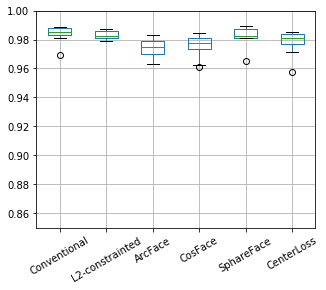

# Stat: Normalized distances


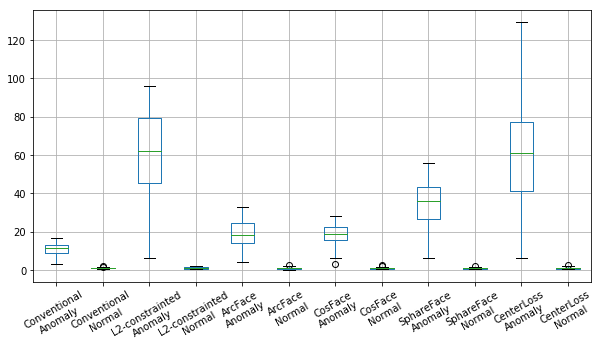


## [0, 1, 2, 3, 4]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
<unk> 0,10.073937,51.808768,12.672111,21.922937,31.051865,72.432807
<unk> 1,15.783623,85.590305,25.578399,17.417105,38.827542,59.551714
<unk> 2,13.760674,82.334129,22.185161,16.245829,55.921542,77.424923
<unk> 3,6.786596,44.159123,17.894980,22.308911,23.311713,47.274120
<unk> 4,11.578393,88.815947,24.746924,20.269119,41.069810,104.869699
5,0.757380,1.007977,1.319201,1.297784,1.035816,0.908611
6,1.102876,1.045924,0.353109,0.609231,2.001480,1.719242
7,1.384672,0.700504,1.109570,1.051382,0.980820,0.966834
8,1.147784,1.362678,1.034101,1.727733,0.921933,1.459907
9,1.127591,2.281655,1.835376,2.663023,0.699940,1.446361



## [1, 2, 3, 4, 5]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
0,0.767304,1.078228,1.104002,0.818074,0.415601,1.214105
<unk> 1,16.598198,80.675718,32.621379,24.753898,36.146310,107.214652
<unk> 2,15.208747,92.613263,29.589142,24.069448,51.477483,76.302002
<unk> 3,13.196467,73.065460,10.894311,23.918169,20.032507,36.637230
<unk> 4,10.960956,80.430374,22.074217,19.715111,53.927550,120.536538
<unk> 5,13.043277,66.296487,15.046119,20.211893,27.742158,40.722200
6,0.877661,1.199499,0.668782,0.807244,1.701095,0.880207
7,0.891011,0.986348,0.675762,1.200517,1.140183,1.303106
8,1.110704,1.755901,1.586491,0.667403,1.017182,1.211306
9,1.012771,1.242039,1.179506,1.252627,1.078156,0.942418



## [2, 3, 4, 5, 6]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
0,0.854492,0.650369,0.311655,0.805986,1.127865,0.615573
1,1.592565,0.809180,0.503609,0.480819,0.872753,1.352224
<unk> 2,12.106910,89.766614,30.453296,20.927572,48.844147,81.413424
<unk> 3,7.758696,63.562507,18.283374,13.315674,29.884448,56.555817
<unk> 4,12.825365,93.235343,27.180911,23.017788,52.286300,99.462930
<unk> 5,6.384366,33.863636,9.581820,9.527388,31.585551,53.654062
<unk> 6,8.729394,58.273004,19.418499,15.184567,33.780285,61.513574
7,1.882234,1.448058,1.157927,1.216022,1.287054,1.236795
8,0.812390,1.733087,0.882605,1.044867,1.195175,1.362026
9,0.994058,1.998432,1.860506,1.071044,1.485815,1.231725



## [3, 4, 5, 6, 7]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
0,1.118052,0.661107,0.651899,0.641716,0.909957,1.040820
1,0.655076,0.565971,0.397218,0.880769,0.476821,1.001727
2,1.250425,0.882784,0.855302,0.715402,1.086812,0.542243
<unk> 3,12.677509,82.546192,24.777974,25.648665,43.402568,83.874683
<unk> 4,10.080992,30.729538,11.984785,11.045306,15.296726,32.411426
<unk> 5,9.732942,53.289969,14.558633,15.979874,33.666516,69.556279
<unk> 6,12.872319,65.577259,15.714984,17.693077,49.635814,68.435226
<unk> 7,15.156197,66.426376,25.589873,18.569485,36.072378,80.826029
8,1.022629,1.463367,2.474394,1.567447,1.073645,2.458493
9,1.377606,1.169593,1.407150,1.517085,0.667949,0.913264



## [4, 5, 6, 7, 8]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
0,0.690503,0.378685,1.249059,0.535547,0.906829,0.865954
1,0.564585,0.657438,0.283841,0.346863,0.379833,0.686697
2,1.178004,0.482249,0.488117,0.864482,0.767734,0.635440
3,0.971292,0.624939,1.030852,1.450883,0.731032,0.856779
<unk> 4,6.373359,31.744525,13.461326,10.716866,18.012890,14.344760
<unk> 5,11.647745,38.215019,14.696767,22.559703,34.199628,39.643167
<unk> 6,8.514154,25.477422,23.002101,8.450128,24.574700,39.373542
<unk> 7,14.664841,66.567147,30.486938,17.503849,41.053500,57.796315
<unk> 8,12.255070,58.114677,18.861846,25.717060,35.501888,67.774994
9,0.497691,0.728520,1.354506,0.859270,1.401452,0.352693



## [5, 6, 7, 8, 9]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
0,0.792923,0.412668,1.092842,0.817715,0.340956,0.683959
1,0.869448,0.674378,0.201153,0.383476,0.316492,0.409741
2,1.512041,0.783555,0.998779,1.152627,0.972896,0.699194
3,0.714737,0.521898,1.043109,0.909142,1.711803,0.512261
4,0.669538,0.368102,1.190139,0.792394,1.065625,0.498437
<unk> 5,3.355046,6.122927,4.236087,2.881358,5.975324,6.184375
<unk> 6,7.694220,52.099961,14.078308,6.313258,24.883809,17.606071
<unk> 7,16.834077,49.911932,25.752242,25.769766,43.289129,129.180549
<unk> 8,8.872365,32.090991,11.433154,10.408338,18.064701,58.742575
<unk> 9,9.528002,31.506575,12.377227,20.509612,26.258322,24.947531



## [6, 7, 8, 9, 0]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
<unk> 0,11.622957,53.187988,13.292718,17.085235,19.401714,42.843288
1,0.729495,0.364627,0.506558,0.309042,0.475855,0.541273
2,1.062392,2.193841,1.217265,0.880456,0.682951,0.431575
3,1.308237,1.396108,0.760677,0.938192,1.141399,1.026628
4,0.727067,0.315963,1.324858,1.134818,0.725510,0.784852
5,0.800157,1.319162,0.990548,1.419284,1.503020,2.177548
<unk> 6,7.610881,71.915868,16.348754,13.503061,37.662972,31.759353
<unk> 7,13.514992,89.720603,13.937103,19.260746,37.281773,90.182686
<unk> 8,13.070077,57.817577,17.768666,28.102593,46.121650,67.148652
<unk> 9,12.897107,63.572202,20.309465,16.819392,39.011119,65.742623



## [7, 8, 9, 0, 1]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
<unk> 0,12.508961,65.707795,16.869071,23.322234,45.080467,40.688127
<unk> 1,7.568718,55.742293,17.513343,20.766429,17.231139,53.925290
2,0.759252,0.641590,1.189274,0.558771,0.809405,0.529962
3,1.778607,1.363775,1.292357,0.935067,0.858818,0.914105
4,0.554778,0.431510,1.621234,1.577802,0.682890,0.634177
5,1.157048,2.082108,1.226406,1.166618,1.564010,1.992363
6,0.764081,0.607647,1.131701,1.166755,0.965700,0.942455
<unk> 7,8.509680,55.950079,16.057714,7.236546,40.326155,83.320787
<unk> 8,16.145213,83.929321,25.563755,21.858067,43.240777,56.527365
<unk> 9,11.067606,41.230396,14.581121,17.383691,13.897110,68.073594



## [8, 9, 0, 1, 2]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
<unk> 0,11.208402,17.379587,4.359688,8.804403,7.398916,16.149677
<unk> 1,12.307232,60.459257,23.870805,23.034393,45.909086,66.063636
<unk> 2,11.931997,91.935421,17.744846,23.207277,54.385633,60.508721
3,1.050518,0.709839,0.657493,0.528151,1.537221,0.496413
4,0.688710,1.184959,0.587474,0.739991,1.234379,0.575436
5,0.951902,1.270683,1.043040,0.866955,1.403695,1.280628
6,0.918045,0.863954,0.277879,0.409187,0.879495,0.732158
7,0.883815,0.928248,1.303142,1.242089,0.537140,1.020954
<unk> 8,9.636057,48.261970,18.299676,16.412358,34.588889,50.107567
<unk> 9,13.998661,68.519640,24.415379,19.590121,35.894574,87.722287



## [9, 0, 1, 2, 3]: normalized mean distance


,Conventional,L2-constrained,ArcFace,CosFace,SphareFace,CenterLoss
<unk> 0,11.382995,33.325342,18.371864,8.740701,32.806523,39.263729
<unk> 1,14.101788,75.567706,20.695645,16.533928,49.689729,53.130593
<unk> 2,8.832792,35.293742,26.619500,20.709150,35.537224,65.889207
<unk> 3,10.547957,68.146546,8.934214,16.211111,40.706406,72.257995
4,1.326841,1.017151,1.005238,1.336588,0.989462,0.561461
5,1.376538,1.036644,0.873201,0.697054,1.308097,1.409381
6,1.161823,0.474024,0.870731,0.812785,1.183769,1.947229
7,0.946799,0.615970,0.585569,2.255402,0.923395,0.558781
8,0.853852,1.507065,1.234795,0.876419,0.823084,1.434483
<unk> 9,14.468865,95.759258,28.877456,24.464374,51.705332,86.095465


In [24]:
toytest.test_summary(auc_range=[0.85, 1.0], dist_range=None)
toytest.save_results('results_AnomalyMNIST')

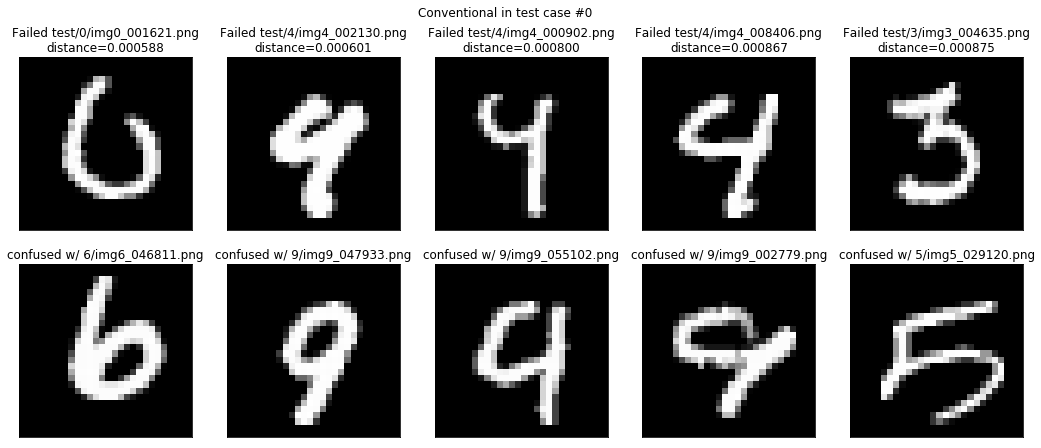

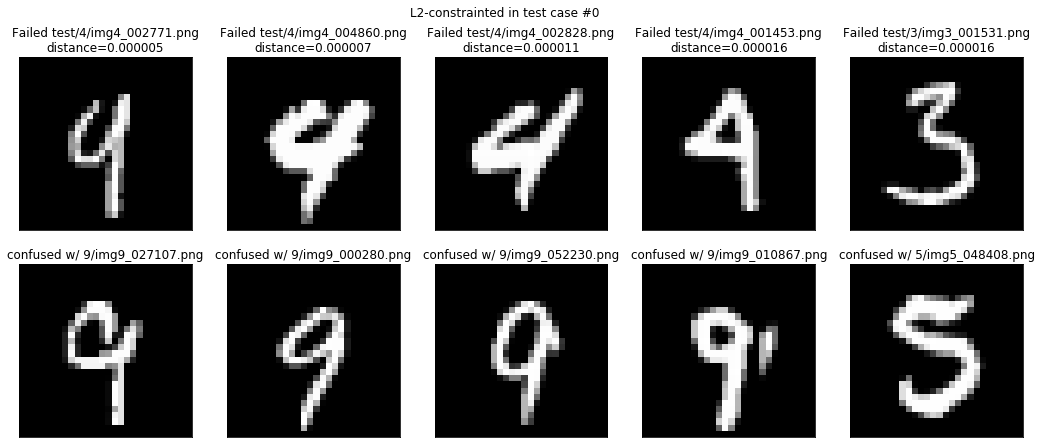

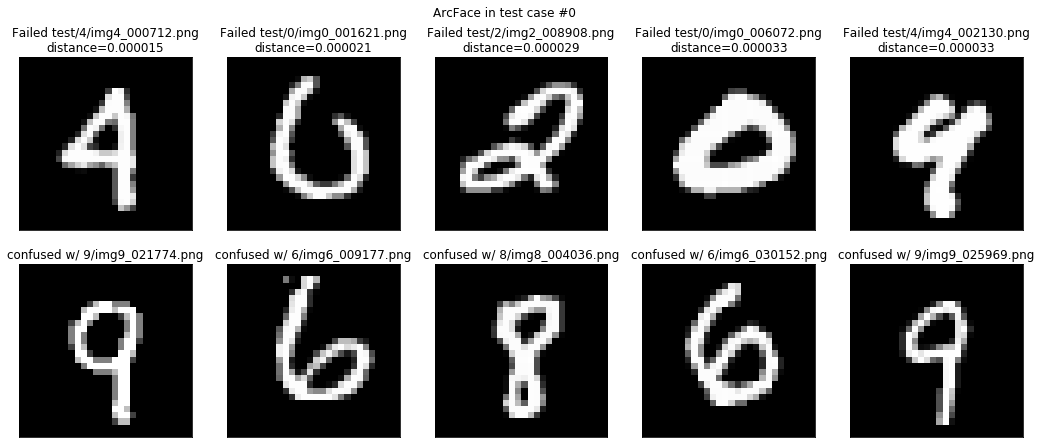

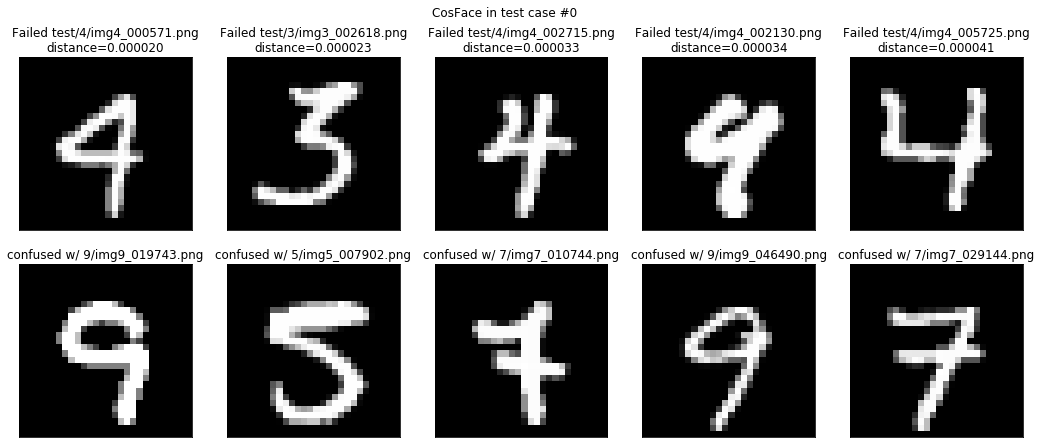

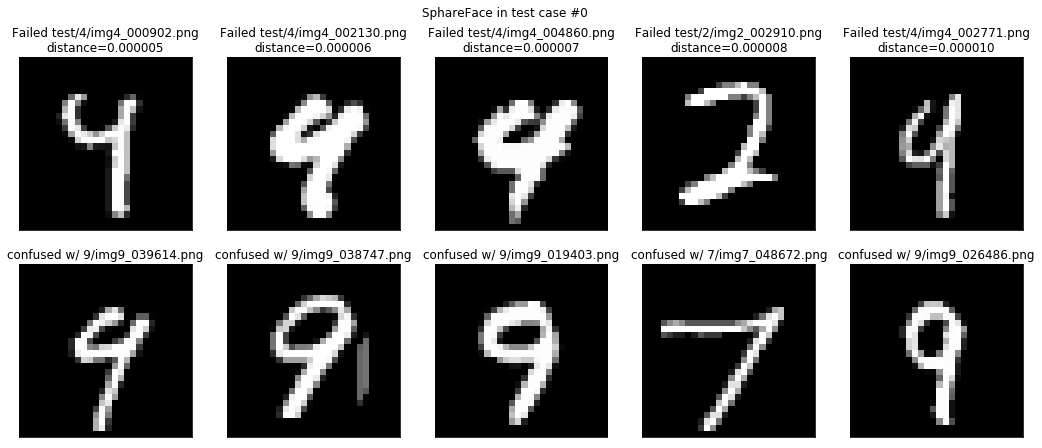

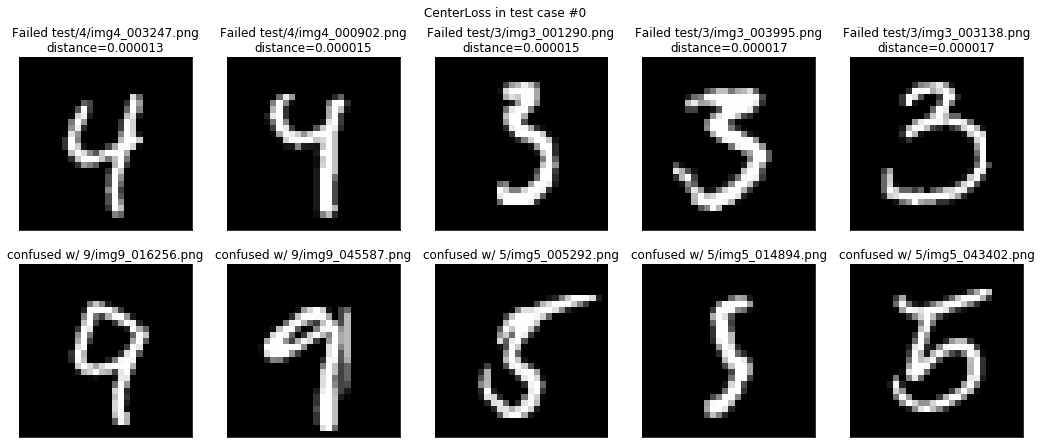

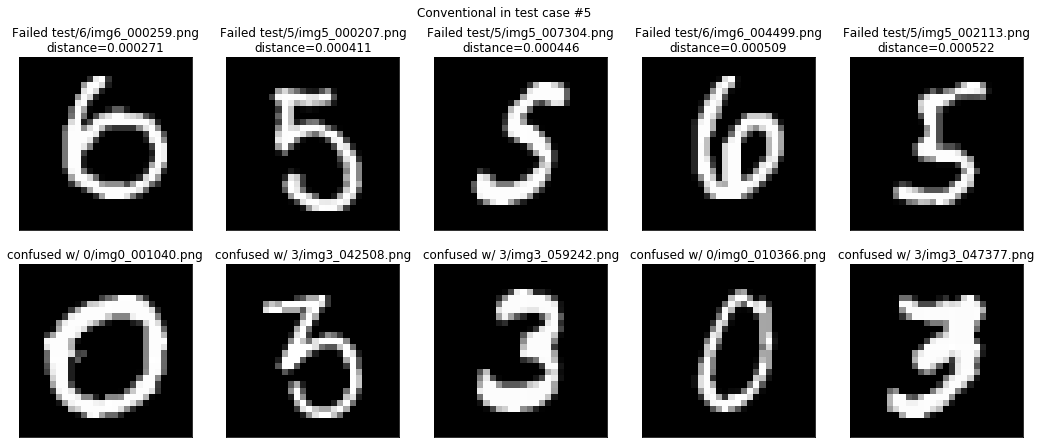

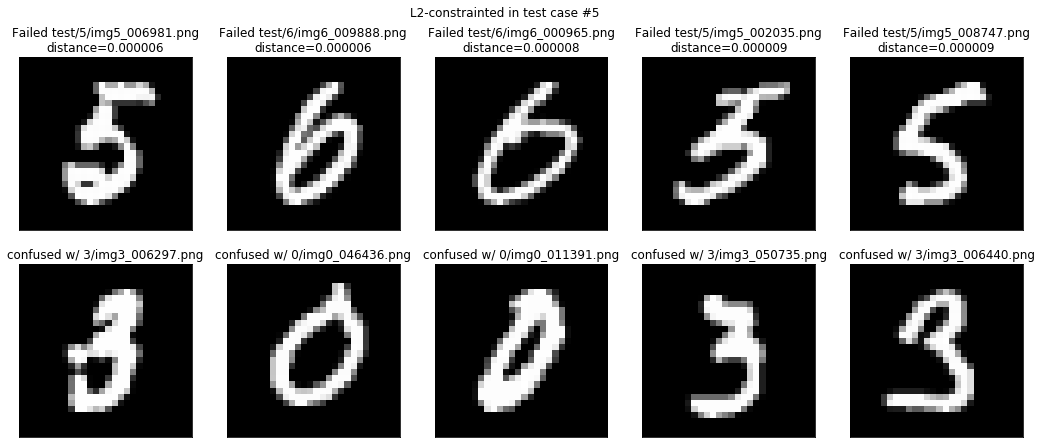

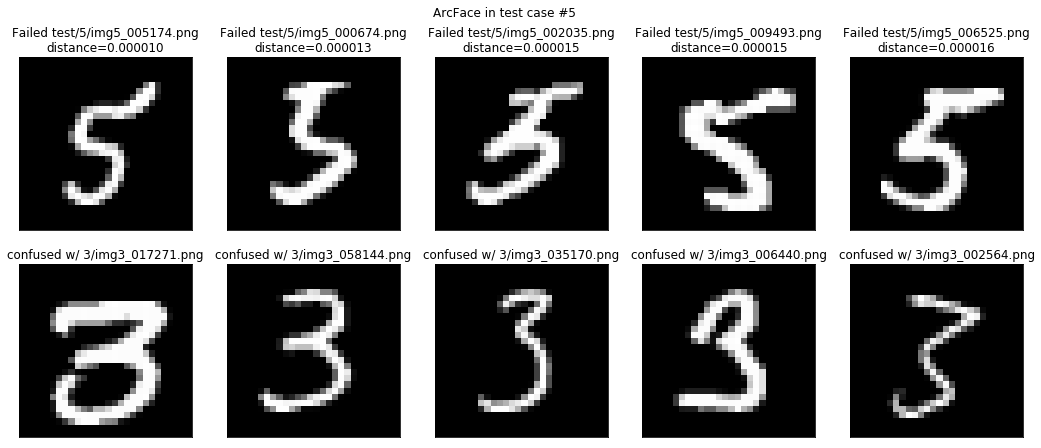

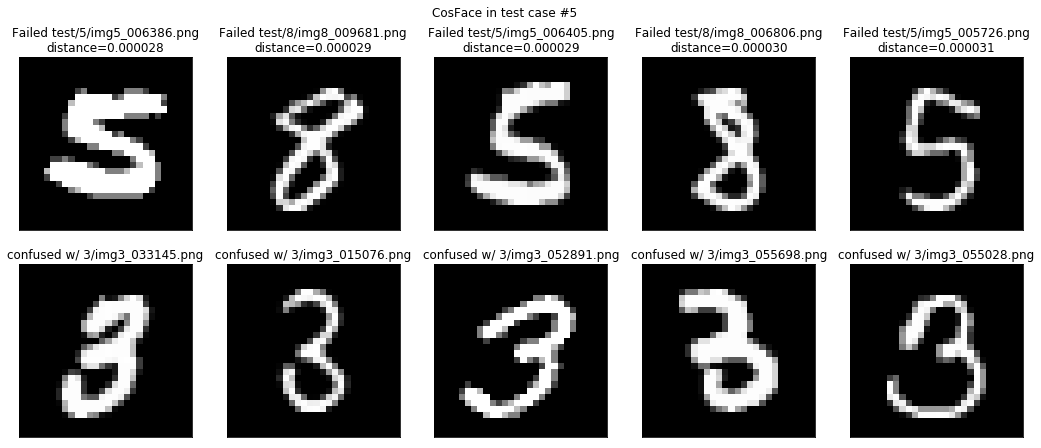

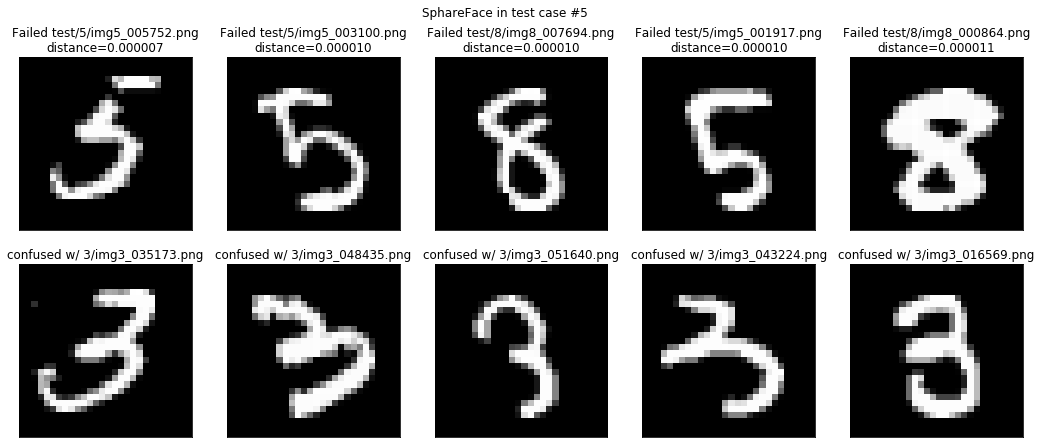

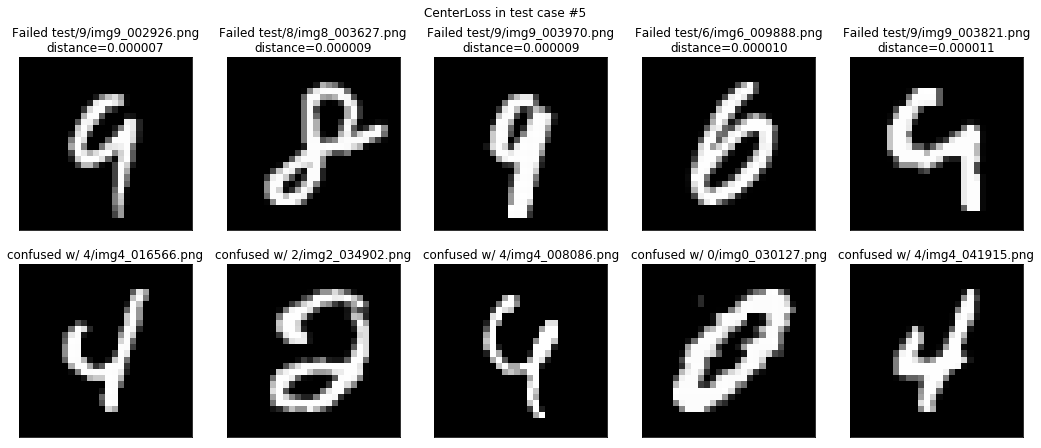

In [20]:
for i in [0, 5]: toytest.show_all_worst_test_images(i)